In [75]:
import numpy as np
import pandas as pd
import paranoid as pns
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate, optimize
import ddm
import ddm.plot
import json

import paranoid as pns
pns.settings.Settings.set(enabled=False)

# pyddm simulation

### Fitting using pyddm

In [39]:
class LossByMeans(ddm.LossFunction):
    # This is a shortcut loss function for optimizing fit to accuracy and mean RT, as opposed to full RT distribution
    name = "Mean correct RT and accuracy"
    def setup(self, dt, T_dur, **kwargs):
        self.dt = dt
        self.T_dur = T_dur
        self.exp_data = pd.read_csv('measures.csv', usecols=['RT', 'is_turn_decision', 'tta_condition'])
        
    def loss(self, model):
        sols = self.cache_by_conditions(model)
        MSE = 0
        for comb in self.sample.condition_combinations(required_conditions=self.required_conditions):
            c = frozenset(comb.items())
            mean_rt_exp_cor = self.exp_data[(self.exp_data.tta_condition == comb['tta_condition']) & 
                                            self.exp_data.is_turn_decision == True].RT.mean()
            comb_sample = self.sample.subset(**comb)
            MSE += (sols[c].prob_correct() - comb_sample.prob_correct())**2
            if sols[c].prob_correct() > 0:
                MSE += (sols[c].mean_decision_time() - mean_rt_exp_cor)**2
        return MSE
    
class LossWLS(ddm.LossFunction):
    name = 'Weighted least squares as described in Ratcliff & Tuerlinckx 2002'
    rt_quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]
    rt_q_weights = [2, 2, 1, 1, 0.5]
    
    def setup(self, dt, T_dur, **kwargs):
        self.dt = dt
        self.T_dur = T_dur
    
    def get_rt_quantiles(self, x, t_domain, exp=False):
        cdf = x.cdf_corr(T_dur=self.T_dur, dt=self.dt) if exp else x.cdf_corr()
        cdf_interp = interpolate.interp1d(t_domain, cdf/cdf[-1])
        rt_quantile_values = [optimize.root_scalar(lambda x:cdf_interp(x)-quantile, bracket=(0, t_domain[-1])).root
                              for quantile in self.rt_quantiles]
        return np.array(rt_quantile_values)
    
    def loss(self, model):
        solultions = self.cache_by_conditions(model)
        WLS = 0
        for comb in self.sample.condition_combinations(required_conditions=self.required_conditions):
            c = frozenset(comb.items())
            comb_sample = self.sample.subset(**comb)
            WLS += 4*(solultions[c].prob_correct() - comb_sample.prob_correct())**2
            if solultions[c].prob_correct() > 0:
                model_rt_q = self.get_rt_quantiles(solultions[c], model.t_domain(), exp=False)
                exp_rt_q = self.get_rt_quantiles(comb_sample, model.t_domain(), exp=True)
                # this can be modified from R&T 2002: *comb_sample.prob_correct() can be removed to improve RT fit at low-p trials
                WLS += np.dot((model_rt_q-exp_rt_q)**2, self.rt_q_weights)*comb_sample.prob_correct()
        return WLS

In [95]:
def get_model_measures(model, tta_condition):
    sol = model.solve(conditions={'tta_condition': tta_condition})
    return tta_condition, sol.prob_correct(), sol.mean_decision_time()
        
def plot_comparison_basic(exp_data, fit_model):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,3))
    model_measures = [get_model_measures(fit_model, tta_condition) for tta_condition in exp_data.tta_condition.unique()]
    model_measures = pd.DataFrame(model_measures, columns=['tta_condition', 'is_turn_decision', 'RT'])
    model_measures['loss'] = fit_model.get_fit_result().value()
    model_measures.to_csv('model_fit_results/measures/%s.csv' % (fit_model.name.lower().replace(' ', '_')), index=False)
    
    sns.pointplot(ax=ax1, data=exp_data, x='tta_condition', y='is_turn_decision', marker='o', color='k', ls='-')
    sns.pointplot(ax=ax1, data=model_measures, x='tta_condition', y='is_turn_decision', marker='s', color='grey')
    ax1.set_ylabel('p(turn)')
    
    sns.pointplot(ax=ax2, data=exp_data[exp_data.is_turn_decision], 
                       x='tta_condition', y='RT', marker='o', color='k', ls='-')
    sns.pointplot(ax=ax2, data=model_measures, x='tta_condition', y='RT', marker='s', color='grey',
                 estimator=np.median)
    
def plot_comparison_rt_pdf(exp_data, fit_model):
    fig, axes = plt.subplots(1,3,figsize=(10,3))
    rt_dfs = []
    for i, tta_condition in enumerate(exp_data.tta_condition.unique()):
        sol = fit_model.solve(conditions={'tta_condition': tta_condition})
        axes[i].plot(fit_model.t_domain(), sol.pdf_corr()/sol.prob_correct(), label='Model')
        sns.distplot(ax=axes[i], a=exp_data[exp_data.is_turn_decision & (exp_data.tta_condition==tta_condition)].RT, 
                    label='Experiment')
        axes[i].set_xlabel('RT')
        axes[i].set_title('TTA=%.0fs' % tta_condition)
        rt_df = pd.DataFrame({'condition': tta_condition,
                              't': fit_model.t_domain(),
                              'rt_corr_pdf': sol.pdf_corr()/sol.prob_correct()})
        rt_dfs.append(rt_df)
#         axes[i].get_legend().remove()
    axes[0].set_ylabel('pdf')
    axes[2].legend(loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    
    rt_dfs = pd.concat(rt_dfs)
    rt_dfs.to_csv('model_fit_results/rt_pdf/%s.csv' % (fit_model.name.lower().replace(' ', '_')), index=False)
    
def visualize_model_fit(exp_data, fit_model):
    print('Loss function value: %.5f' % (fit_model.get_fit_result().value()))
    print('Parameters: ', fit_model.get_model_parameters())
    plot_comparison_basic(exp_data, fit_model)
    plot_comparison_rt_pdf(exp_data, fit_model)

In [36]:
exp_data = pd.read_csv('measures.csv', usecols=['RT', 'is_turn_decision', 'tta_condition'])
exp_sample = ddm.Sample.from_pandas_dataframe(df=exp_data, rt_column_name='RT', correct_column_name='is_turn_decision')

### DDM with fixed drift 

In [580]:
class DriftPerCondition(ddm.models.Drift):
    name = 'Fixed drift depending on TTA condition'
    required_parameters = ['alpha', 'tta_crit']
    required_conditions = ['tta_condition'] 
    
    def get_drift(self, conditions, **kwargs):
        return self.alpha*(conditions['tta_condition'] - self.tta_crit)

In [581]:
model_fixed_drift = ddm.Model(name='Model with drift depending on TTA condition',
                             drift=DriftPerCondition(alpha=ddm.Fittable(minval=0.1, maxval=3),
                                                     tta_crit=ddm.Fittable(minval=2, maxval=6)),
                             noise=ddm.NoiseConstant(noise=1),
                             bound=ddm.BoundConstant(B=ddm.Fittable(minval=.1, maxval=3.0)),
                             overlay=ddm.OverlayNonDecisionUniform(nondectime=ddm.Fittable(minval=0, maxval=0.5),
                                                                   halfwidth=ddm.Fittable(minval=0.0, maxval=0.25)),
                             T_dur=2.5)

In [ ]:
%time fit_model_fixed_drift = ddm.fit_adjust_model(sample=exp_sample, model=model_fixed_drift, lossfunction=LossWLS)

Loss function value: 0.01331
Parameters:  [Fitted(0.8513831930404899, minval=0.1, maxval=3), Fitted(5.3594166890062525, minval=2, maxval=6), 1, Fitted(0.5086444554700421, minval=0.1, maxval=3.0), Fitted(0.3679544813398774, minval=0, maxval=0.5), Fitted(0.24610488357204344, minval=0.0, maxval=0.25)]


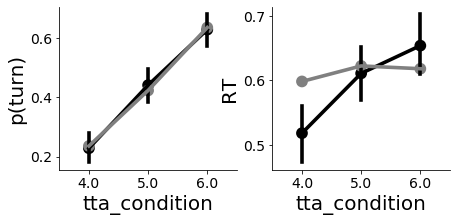

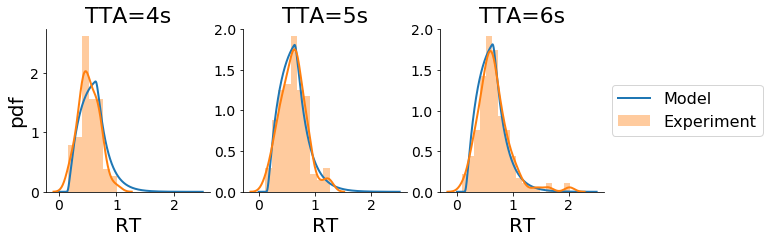

In [578]:
visualize_model_fit(exp_data, fit_model_fixed_drift)

### DDM with variable drift

In [62]:
class DriftTta(ddm.models.Drift):
    name = 'Drift depends on time and critical TTA (parameter)'
    required_parameters = ['alpha', 'tta_crit']
    required_conditions = ['tta_condition'] 
    
    def get_drift(self, t, conditions, **kwargs):
        return self.alpha*(conditions['tta_condition'] - t - self.tta_crit)

In [566]:
model_var_drift = ddm.Model(name='Model with drift depending on TTA',
                 drift=DriftTta(alpha=ddm.Fittable(minval=0.1, maxval=5), 
                                tta_crit=ddm.Fittable(minval=2, maxval=6)),
                 noise=ddm.NoiseConstant(noise=1),
                 bound=ddm.BoundConstant(B=ddm.Fittable(minval=.1, maxval=3.0)),
                 overlay=ddm.OverlayNonDecisionUniform(nondectime=ddm.Fittable(minval=0, maxval=0.5),
                                                       halfwidth=ddm.Fittable(minval=0.0, maxval=0.25)),
                 T_dur=2.5)

In [572]:
model_var_drift = ddm.Model(name='Model with drift depending on TTA',
                 drift=DriftTta(alpha=0.5, tta_crit=5.3),
                 noise=ddm.NoiseConstant(noise=1),
                 bound=ddm.BoundConstant(B=0.8),
                 T_dur=2.5)

In [ ]:
model_var_drift.solve(conditions={'tta_condition': 4})

In [ ]:
%time fit_model_var_drift = ddm.fit_adjust_model(sample=exp_sample, model=model_var_drift, lossfunction=LossWLS)

Loss function value: 0.01241
Parameters:  [Fitted(0.8235651268278356, minval=0.1, maxval=5), Fitted(5.129989561701033, minval=2, maxval=6), 1, Fitted(0.5281660572557432, minval=0.1, maxval=3.0), Fitted(0.3639346487730437, minval=0, maxval=0.5), Fitted(0.24617238403322245, minval=0.0, maxval=0.25)]


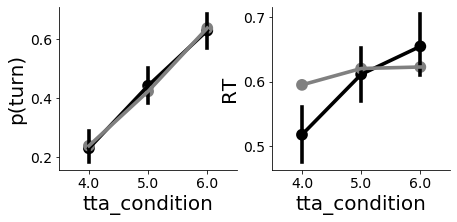

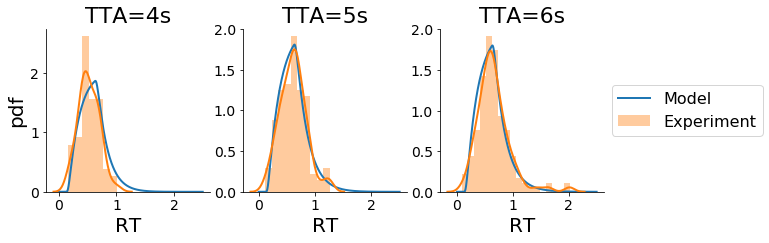

In [538]:
visualize_model_fit(exp_data, fit_model_var_drift)

### DDM with tta-dependent drift and collapsing bounds

In [526]:
model_collapsing_bounds = ddm.Model(name='Model with drift depending on TTA & collapsing bounds',
                 drift=DriftTta(alpha=ddm.Fittable(minval=0.1, maxval=5), 
                                tta_crit=ddm.Fittable(minval=2, maxval=6)),
                 noise=ddm.NoiseConstant(noise=1),
                 bound=ddm.BoundCollapsingExponential(B=ddm.Fittable(minval=0.5, maxval=5), 
                                                     tau=ddm.Fittable(minval=0.5, maxval=5)),
                 overlay=ddm.OverlayNonDecisionUniform(nondectime=ddm.Fittable(minval=0, maxval=0.5),
                                                       halfwidth=ddm.Fittable(minval=0.0, maxval=0.25)),
                 T_dur=2.5)

In [ ]:
%time fit_model_collapse = ddm.fit_adjust_model(sample=exp_sample, model=model_collapsing_bounds, lossfunction=LossWLS)

Loss function value: 0.01525
Parameters:  [Fitted(0.7940308998044414, minval=0.1, maxval=5), Fitted(5.133635640620526, minval=2, maxval=6), 1, Fitted(0.6221629763729744, minval=0.5, maxval=5), Fitted(0.5020588731230347, minval=0.5, maxval=5), Fitted(0.33172547774601235, minval=0, maxval=0.5), Fitted(0.24531473502661966, minval=0.0, maxval=0.25)]


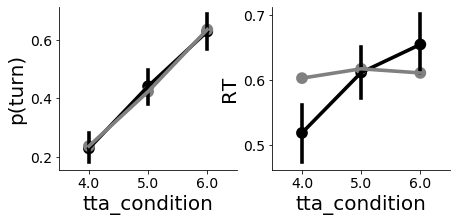

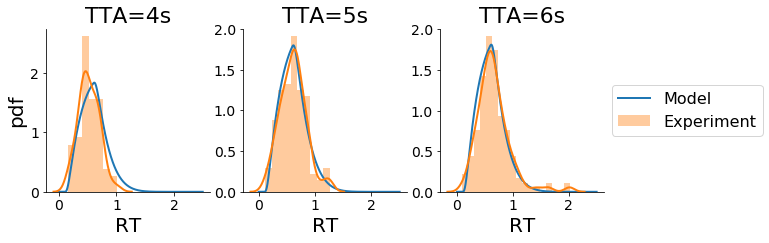

In [539]:
visualize_model_fit(exp_data, fit_model_collapse)

### DDM with tta-dependent bounds

The effect that I want to capture is that close to $\tau_{crit}$ the accumulation should become faster...

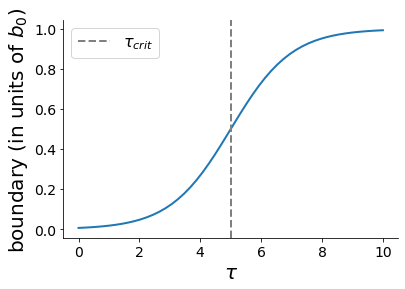

In [27]:
b_0 = 1
k = 1
tta_crit = 5
tau = np.linspace(0, 10)
b = lambda tau: b_0/(1+np.exp(-k*(tau-tta_crit)))

fig, ax = plt.subplots()
ax.plot(tau, b(tau))
ax.axvline(tta_crit, color='grey', ls='--', label=r'$\tau_{crit}$')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('boundary (in units of $b_0$)')
ax.legend()

In [60]:
class BoundCollapsingTta(ddm.models.Bound):
    name = 'Bounds collapsing with TTA'
    required_parameters = ['b_0', 'k', 'tta_crit']
    required_conditions = ['tta_condition'] 
    def get_bound(self, t, conditions, **kwargs):
        tau = conditions['tta_condition'] - t
        return self.b_0/(1+np.exp(-self.k*(tau-self.tta_crit)))

In [61]:
tta_crit=ddm.Fittable(minval=3, maxval=6)

model_collapsing_bounds_tta = ddm.Model(name='Model with both drift and collapsing bounds depending on TTA',
                 drift=DriftTta(alpha=ddm.Fittable(minval=0.1, maxval=5), tta_crit=tta_crit),
                 noise=ddm.NoiseConstant(noise=1),
                 bound=BoundCollapsingTta(b_0=ddm.Fittable(minval=0.5, maxval=5), 
                                              k=ddm.Fittable(minval=0.5, maxval=2),
                                              tta_crit=tta_crit),
                 overlay=ddm.OverlayNonDecisionUniform(nondectime=ddm.Fittable(minval=0.0, maxval=0.5),
                                                       halfwidth=ddm.Fittable(minval=0.0, maxval=0.25)),
                 T_dur=2.5)

In [ ]:
%time fit_model_collapse = ddm.fit_adjust_model(sample=exp_sample, model=model_collapsing_bounds_tta, lossfunction=LossWLS)

Loss function value: 0.02119
Parameters:  [Fitted(1.092125011250939, minval=0.1, maxval=5), Fitted(5.252080871011812, minval=3, maxval=6), 1, Fitted(1.0205552605932182, minval=0.5, maxval=5), Fitted(0.5019674287736253, minval=0.5, maxval=2), Fitted(5.252080871011812, minval=3, maxval=6), Fitted(0.3793938659271093, minval=0.0, maxval=0.5), Fitted(0.24931842614839736, minval=0.0, maxval=0.25)]


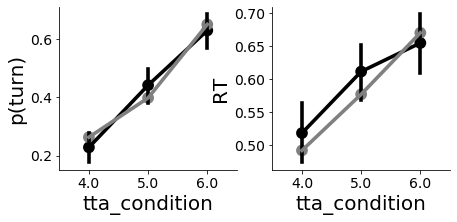

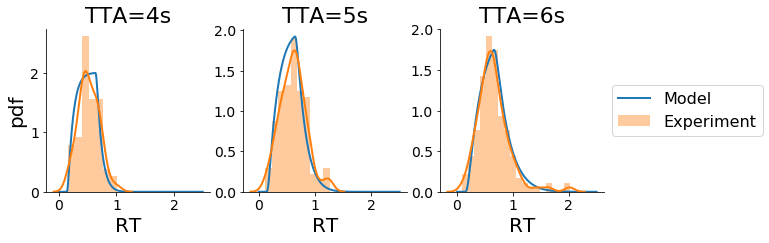

In [97]:
visualize_model_fit(exp_data, fit_model_collapse)

# Custom simulation

In [53]:
def plot_comparison_basic(exp_data, model_measures):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,3))
    
    sns.pointplot(ax=ax1, data=exp_data, x='tta_condition', y='is_turn_decision', marker='o', color='k', ls='-')
    sns.pointplot(ax=ax1, data=model_measures, x='tta_condition', y='is_turn_decision', marker='s', color='grey')
    ax1.set_ylabel('p(turn)')
    
    sns.pointplot(ax=ax2, data=exp_data[exp_data.is_turn_decision], 
                       x='tta_condition', y='RT', marker='o', color='k', ls='-')
    sns.pointplot(ax=ax2, data=model_measures, x='tta_condition', y='RT', marker='s', color='grey',
                 estimator=np.median)
    
def plot_comparison_rt_pdf(exp_data, model_measures):
    fig, axes = plt.subplots(1,3,figsize=(10,3))
    for i, tta_condition in enumerate(exp_data.tta_condition.unique()):
        sns.distplot(ax=axes[i], a=model_measures[model_measures.is_turn_decision & (model_measures.tta_condition==tta_condition)].RT, 
                    label='Model', hist=False)
        sns.distplot(ax=axes[i], a=exp_data[exp_data.is_turn_decision & (exp_data.tta_condition==tta_condition)].RT, 
                    label='Experiment')
        axes[i].set_xlabel('RT')
        axes[i].set_title('TTA=%.0fs' % tta_condition)
        axes[i].get_legend().remove()
    axes[0].set_ylabel('pdf')
    axes[2].legend(loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    
def visualize_model_fit(exp_data, model_measures):
#     print('Loss function value: %.5f' % (fit_model.get_fit_result().value()))
#     print('Parameters: ', fit_model.get_model_parameters())
    plot_comparison_basic(exp_data, model_measures)
    plot_comparison_rt_pdf(exp_data, model_measures)

### DDM

There is something strange when I run the simulation with pyddm: constant tta-based drift rate results in almost the same outcome as decreasing drift rate. Let's see if this is reproduced in the custom simulation.

In [89]:
def drift_tta_dynamic(condition, params, t_max, dt):
    tta_condition, distance_condition = condition
    alpha, tta_crit, boundary, delay_min, delay_max = params
    tau = np.tile(np.arange(tta_condition, tta_condition-t_max, -dt), n_sim)
    drift = alpha*(tau-tta_crit)
    return drift

def drift_tta_static(condition, params, t_max, dt):
    tta_condition, distance_condition = condition
    alpha, tta_crit, boundary, delay_min, delay_max = params
    drift = alpha*(tta_condition-tta_crit)
    return drift

def get_measures(trial_data, boundary):
    threshold_crossed = np.where(abs(trial_data.x)>boundary)[0]
    if len(threshold_crossed)>0:
        i_decision = threshold_crossed[0]
        is_turn_decision = trial_data.x.values[i_decision] > 0
        RT = trial_data.t.values[i_decision]
    else:
        is_turn_decision = False
        RT = 0
    
    return pd.Series([is_turn_decision, RT])

def run_sim(drift_function, condition, params, n_sim=1000, t_max=2.5, dt=0.0001):
    tta_condition, distance_condition = condition
    alpha, tta_crit, boundary_0, delay_min, delay_max = params
    n_steps = int(t_max/dt)
    trial_no = np.repeat(np.arange(n_sim), n_steps)
    
    t = np.arange(0, t_max, dt)
    i = np.tile(np.arange(n_steps), n_sim)
    
    drift = drift_function(condition, params, t_max, dt)
    
    noise = np.random.randn(n_sim*n_steps)
    
    dx = drift*dt + noise*np.sqrt(dt)
    sim_result = pd.DataFrame({'trial_no': trial_no,
                               't': i*dt,
                               'dx': dx})
    sim_result['x'] = sim_result.groupby('trial_no')['dx'].transform(pd.Series.cumsum)
    
#     boundary = boundary_0
    tau_b = 3
    boundary = boundary_0*np.exp(t/tau_b)
    
    measures = sim_result.groupby('trial_no').apply(lambda z: get_measures(z, boundary))
    measures.columns = ['is_turn_decision', 'RT']
    
    nondecision_time = np.random.uniform(delay_min, delay_max, n_sim)    
    measures['RT'] += nondecision_time
    measures['tta_condition'] = tta_condition
    measures['d_condition'] = distance_condition
    
    return measures

def get_model_sim_results(drift_function, params):  
    return pd.concat([run_sim(drift_function, condition=(tta, 90), params=params) for tta in [4, 5, 6]])

In [69]:
condition = (6, 90)
params = (0.82, 5.13, 0.53, 0.1, 0.6)
n_sim=1000
t_max=2.5
dt=0.001

In [90]:
%time model_measures_static = get_model_sim_results(drift_function=drift_tta_static, params=params)

Wall time: 22.9 s


In [91]:
%time model_measures_dynamic = get_model_sim_results(drift_function=drift_tta_dynamic, params=params)

Wall time: 22 s


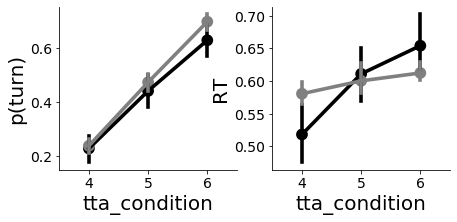

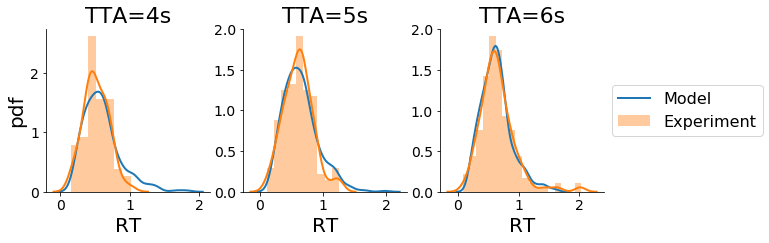

In [92]:
visualize_model_fit(exp_data, model_measures_static)

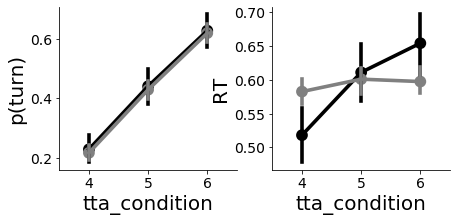

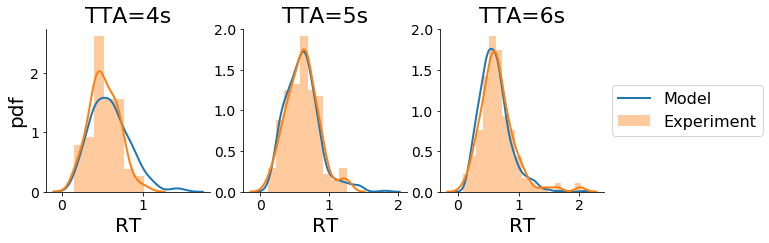

In [93]:
visualize_model_fit(exp_data, model_measures_dynamic)

In [111]:
exp_measures[exp_measures.is_turn_decision].groupby('tta_condition').RT.median()

tta_condition
4.0    0.49445
5.0    0.60200
6.0    0.61830
Name: RT, dtype: float64

In [113]:
model_measures_dynamic[model_measures_static.is_turn_decision].groupby('tta_condition').RT.median()

tta_condition
4    0.603605
5    0.580031
6    0.593666
Name: RT, dtype: float64

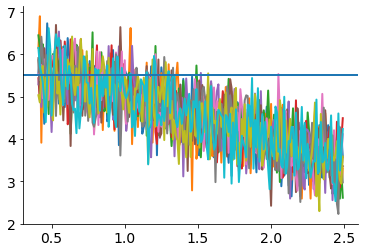

In [459]:
condition = (6, 90)
params = (0.5, 0.4, 5.5)
tta_condition, distance_condition = condition
noise_intensity, nondecision_time, tta_crit = params
n_sim=1000
t_max=2.5
dt=0.01

noise = np.random.randn(n_sim, int(t_max/dt))
tau = np.arange(tta_condition, tta_condition-t_max, -dt)
x = tau + noise_intensity*noise
x[:,tta_condition-tau<nondecision_time] = np.nan

fig, ax = plt.subplots(1)
for x_i in x[:10]:
    ax.plot(tta_condition-tau, x_i)
    
ax.axhline(tta_crit)

In [55]:
def plot_comparison(exp_measures, sim_measures):
    ax = sns.pointplot(data=exp_measures, x='tta_condition', y='is_turn_decision', marker='o', color='k', ls='-')
    sns.pointplot(ax=ax, data=sim_measures, x='tta_condition', y='is_turn_decision', marker='o', color='grey')
    ax.set_ylabel('p(turn)')
    plt.figure()
    ax = sns.pointplot(data=exp_measures[exp_measures.is_turn_decision], 
                       x='tta_condition', y='RT', marker='o', color='k', ls='-')
    sns.pointplot(ax=ax, data=sim_measures[sim_measures.is_turn_decision], 
                  x='tta_condition', y='RT', marker='o', color='grey')
    
def plot_ddm_traces(sim_data, axes=None):
    turn_rate = sim_data.groupby('n').is_turn_decision.last().mean()
    mean_turn_rt = sim_data[sim_data.is_turn_decision].groupby('n').t.last().mean()
    
    if axes is None:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4), sharex=True)
        axes = (ax1, ax2, ax3)
    else:
        (ax1, ax2, ax3) = axes
     
    for n, traj in sim_data.groupby('n'):
        is_turn_decision = traj.is_turn_decision.iloc[-1]
        color = 'C1' if is_turn_decision else 'C2'
        alpha = 0.3 if is_turn_decision else 0.1
        ax1.plot(traj.t, traj.x, color=color, alpha=alpha)
        ax2.plot([traj.t.values[-1]], [traj.d.values[-1]], color=color, marker='o', alpha=alpha)
    
    response_times = sim_data[sim_data.is_turn_decision].groupby('n').t.last()
    sns.kdeplot(ax=ax3, data=response_times, color='C1', shade=True, legend=False)
    
    for ax in axes:
        ax.set_xlim((0, response_times.max()))

    ax1.set_ylabel('evidence $x$')
    ax2.set_ylabel('$tta-tta_{crit}$')
    ax3.set_ylabel('probability')    
    
    ax1.set_xlabel('time $t$')
    ax2.set_xlabel('time $t$')
    ax3.set_xlabel('RT')
    
    ax2.set_title('Turn rate$=%.f\%%$, mean turn RT $=%.2f$s' % (100*turn_rate, mean_turn_rt))
    plt.subplots_adjust(hspace=0.2)
    sns.despine(trim=True, offset=5)
    
    return axes

Wall time: 1min


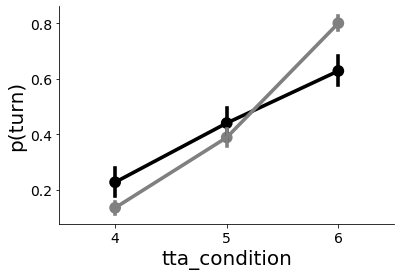

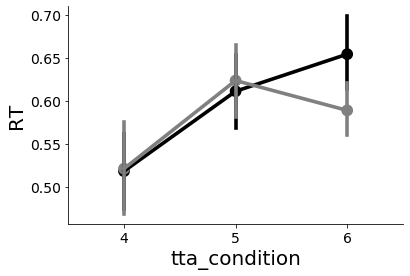

In [57]:
%time sim_results = get_model_sim_results(params=(1,1,4.5))
sim_measures = (sim_results.groupby(['tta_condition', 'n']).last().reset_index()
                .rename(columns={'t': 'RT'}).drop(columns=['n', 'x', 'd']))
exp_measures = pd.read_csv('measures.csv')
plot_comparison(exp_measures, sim_measures)

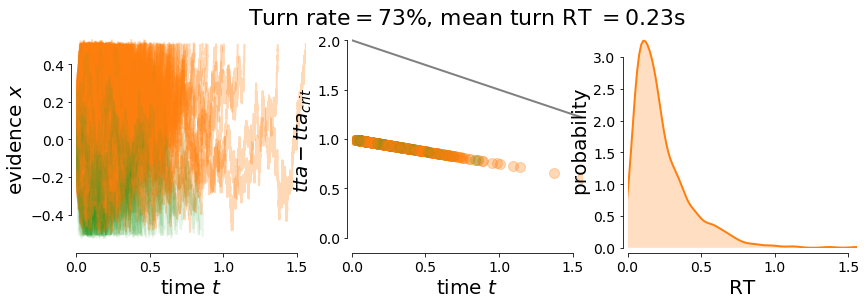

In [46]:
plot_ddm_traces(sim_results[sim_results.tta_condition==4]);

In [141]:
def model_error_wls_per_condition(sim_measures, exp_measures):
    # weighted least squares fitting, as described in Ratcliff & Tuerlinckx 2002   
    p_exp = exp_measures.is_turn_decision.mean()
    p_model = sim_measures.is_turn_decision.mean()
    delta_p = (p_model - p_exp)**2

    rt_quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]
    rt_q_weights = [2, 2, 1, 1, 0.5]
    
    model_rt_quantiles = sim_measures[sim_measures.is_turn_decision].RT.quantile(rt_quantiles)
    exp_rt_quantiles = exp_measures[exp_measures.is_turn_decision].RT.quantile(rt_quantiles)    
    
    return 4*delta_p + np.dot((model_rt_quantiles-exp_rt_quantiles)**2, rt_q_weights)*p_exp

def model_error_wls(sim_measures, exp_measures):
    error = [model_error_wls_per_condition(sim_measures[sim_measures.tta_condition==tta],
                                           exp_measures[exp_measures.tta_condition==tta]) for tta in [4, 5, 6]]
    return sum(error)

def f_wls(params):    
    exp_measures = pd.read_csv('measures.csv')
    sim_results = get_model_sim_results(params)
    sim_measures = (sim_results.groupby(['tta_condition', 'n']).last().reset_index()
                    .rename(columns={'t': 'RT'}).drop(columns=['n', 'x', 'd']))
    f = model_error_wls(sim_measures, exp_measures)
    print(f, params)
    return f

In [65]:
# alpha, boundary, tta_crit = params
ranges = (slice(0.1, 3.2, 1.0), slice(0.1, 3.2, 1.0), slice(4.0, 5.1, 0.5))
%time params_opt, fval, grid, jout = optimize.brute(f_wls, ranges=ranges, Ns=2, full_output=True, finish=None)

2.787442727819862
2.783386489843026
2.8332460458188757
1.6485192251859284
1.9179245828287628
1.7360595502260614
13.860893945353602
13.566686608641302
13.834017791780667
28.168151934621545
29.747443670987792
28.21839090300231
2.793772186940395
2.734440521313453
2.713832849598502
0.6678972157909966
0.37700493750527886
0.5249226255777395
1.6950880536775315
2.4186959848325866
2.5030809990488336
nan
nan
nan
2.880906686793896
2.685083521153019
2.5770801646664134
1.5250714931285358
1.0190486002103278
0.9609450879485784
0.9567267518226564
nan
nan
nan
nan
nan
3.049041003695492
2.6992237470908336
2.515207890474943
2.280203290332218
1.3720435918194673
nan
nan
nan
nan
nan
nan
nan
Wall time: 1h 26min 52s


In [142]:
i, j, k = np.unravel_index(np.nanargmin(jout), jout.shape)
params_opt = [grid[0][i][0][0], grid[1][0][j][0], grid[2][0][0][k]] 
%time f_wls(params_opt)

0.3547671013430629 [1.1, 1.1, 4.5]
Wall time: 1min 18s


0.3547671013430629